In [65]:
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, roc_curve,auc
from sklearn.tree import DecisionTreeClassifier, plot_tree
#import gridsearchcv and lasso and kfold
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')
# Use GBC to predict the outcome
from sklearn.ensemble import GradientBoostingClassifier

**Pre-process the data**

In [101]:
training = pd.read_csv("training.csv")
test = pd.read_csv("test.csv")

all_data = pd.concat([training, test], axis=0, ignore_index=True)

all_data['outcome'] = (all_data['metric_locked_percent_first_114_lockable_days_v1']>0.7).astype(int)
all_data = all_data.drop(columns=['finance_order_id','metric_locked_percent_first_114_lockable_days_v1'])
all_data['weekend'] = all_data['time_day_of_week_v1'].apply(lambda x: x in [5,6,7]).astype(int)

#Drop columns that have 90% missing values
listNAN = all_data.isna().sum()/all_data.shape[0]
listNAN = listNAN[listNAN>0.9999]

all_data=all_data.drop(columns=listNAN.index)

#Store outcome y y_test and y_train
y = all_data['outcome']
y_test = y.iloc[training.shape[0]:]
y_train_full = y.iloc[:training.shape[0]]

/var/folders/7n/r8rrh9ss6q9b_lyhlmx1x_hw0000gn/T/ipykernel_47169/235163665.py:1: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  training = pd.read_csv("training.csv")
/var/folders/7n/r8rrh9ss6q9b_lyhlmx1x_hw0000gn/T/ipykernel_47169/235163665.py:2: DtypeWarning: Columns (28,139) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv("test.csv")


In [67]:
features=all_data.columns
#Remove 'outcome from features
features = features.drop('outcome')

In [68]:
#split features into categorical and numerical
cat_features = all_data[features].select_dtypes(include=['object']).columns
num_features = all_data[features].select_dtypes(exclude=['object']).columns

all_data_cat = pd.get_dummies(all_data[cat_features], drop_first = True, dummy_na = True)
all_data_num = all_data[num_features]

#store only the categorical features in a list
all_data_cat.rename(columns={'merchant_state_v1_nuevo león':'merchant_state_v1_nuevoLeon'},inplace=True)
all_data_cat['merchant_state_v1_nuevoLeon'] = all_data_cat['merchant_state_v1_nuevoLeon'] + all_data_cat['merchant_state_v1_nuevo leon']
all_data_cat = all_data_cat.drop(columns=['merchant_state_v1_nuevo leon'])
cat_features = all_data_cat.columns

all_data_binned=pd.concat([all_data_num,all_data_cat,y],axis=1)

print(all_data_binned.shape)

(50000, 1303)


In [69]:
training_processed = all_data_binned.iloc[0:len(training),:]
test_processed = all_data_binned.iloc[len(training):len(all_data_binned),:]

#separate training_processed and test_processed into training_processed_cat and training_processed_num
training_processed_cat = training_processed[cat_features]
training_processed_num = training_processed[num_features]

test_processed_cat = test_processed[cat_features]
test_processed_num = test_processed[num_features]


In [70]:
#impute missing values in training_processed with mean of the column for numerical features and mode for categorical features using SimpleImputer
from sklearn.impute import SimpleImputer
imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_cat = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)

training_processed_num = imp_num.fit_transform(training_processed_num)
test_processed_num = imp_num.transform(test_processed_num)

training_processed_cat = imp_cat.fit_transform(training_processed_cat)
test_processed_cat = imp_cat.transform(test_processed_cat)

In [111]:
#convert training_processed_num and test_processed_num to dataframe
training_processed_num = pd.DataFrame(training_processed_num, columns=num_features)
test_processed_num = pd.DataFrame(test_processed_num, columns=num_features)

#convert training_processed_cat and test_processed_cat to dataframe
training_processed_cat = pd.DataFrame(training_processed_cat, columns=cat_features)
test_processed_cat = pd.DataFrame(test_processed_cat, columns=cat_features)

#concatenate training_processed_cat and training_processed_num
training_processed = pd.concat([training_processed_num,training_processed_cat], axis = 1)

#create test_processed by joining test_processed_cat and test_processed_num
test_processed = pd.concat([test_processed_num,test_processed_cat], axis = 1)

print(training_processed.shape)
print(test_processed.shape)

(25000, 1302)
(25000, 1302)


In [110]:
features=all_data_binned.columns
#Remove 'outcome from features
features = features.drop('outcome')

In [119]:
n_mock_training = int(len(training_processed)*0.8)

mock_training = training_processed.iloc[0:n_mock_training,:]
mock_test = training_processed.iloc[n_mock_training:len(training_processed),:]

X_train = mock_training.loc[:,features]
y_train = all_data_binned.iloc[0:n_mock_training,-1]

X_test = mock_test.loc[:,features]
y_test = all_data_binned.iloc[n_mock_training:len(training_processed),-1]

**Models**

AUC of GBM model is 0.6660816577235597 



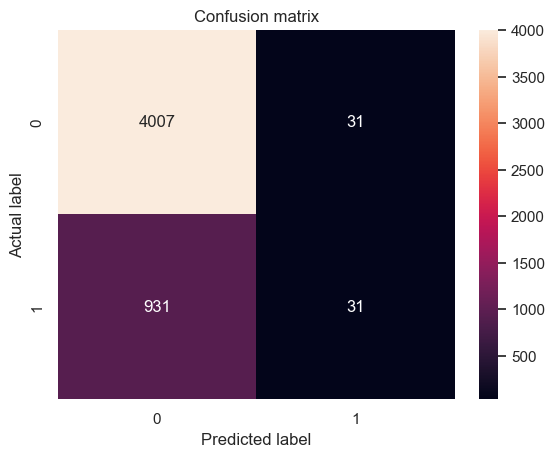

,Id,Predicted
0,2025000,0.144611
1,2025001,0.165463
2,2025002,0.122129
3,2025003,0.116386
4,2025004,0.319734


In [158]:
modelGBM = GradientBoostingClassifier(n_estimators=154) #n_estimators denotes the number of trees that are constructed 155
modelGBM.fit(X_train,y_train)

validationProbsGBM  = modelGBM.predict_proba(X_test)[:,1]
print('AUC of GBM model is',roc_auc_score(y_test, validationProbsGBM),'\n')

probsGBM=modelGBM.predict_proba(test_processed.loc[:,features])[:,1]

#plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, modelGBM.predict(X_test))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


submission = pd.DataFrame(columns = ['Id', 'Predicted'])
submission['Id'] = test['finance_order_id'].reset_index(drop=True)  # matching the id's of the test set, valid as long as we never permuted rows of the data
submission['Predicted'] = probsGBM
submission.to_csv("GBMBest.csv",index = False)
submission.head()

In [159]:
modelGBM.fit(training_processed.loc[:,features],y_train_full)

validationProbsGBM  = modelGBM.predict_proba(X_test)[:,1]
print('AUC of GBM model is',roc_auc_score(y_test, validationProbsGBM),'\n')

probsGBM=modelGBM.predict_proba(test_processed.loc[:,features])[:,1]

print(probsGBM)

submission = pd.DataFrame(columns = ['Id', 'Predicted'])
submission['Id'] = test['finance_order_id'].reset_index(drop=True)  # matching the id's of the test set, valid as long as we never permuted rows of the data
submission['Predicted'] = probsGBM
submission.to_csv("GBMOverfitted.csv",index = False)
submission.head()

AUC of GBM model is 0.7743776894965603 

[0.14377304 0.15885911 0.11732241 ... 0.16826227 0.09580488 0.16734332]


,Id,Predicted
0,2025000,0.143773
1,2025001,0.158859
2,2025002,0.117322
3,2025003,0.143889
4,2025004,0.293123


AUC of XGBoost model is 0.6657655340790556 



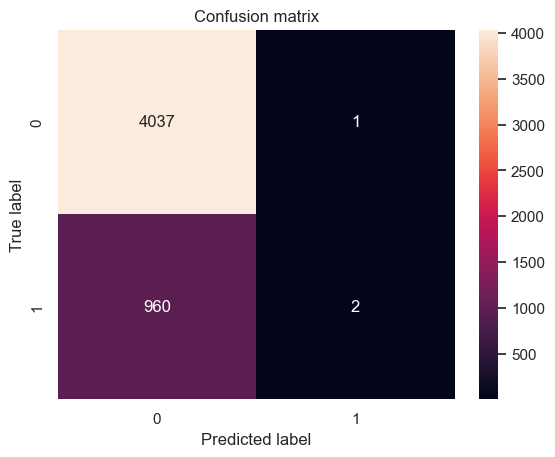

,Id,Predicted
0,2025000,0.144336
1,2025001,0.166544
2,2025002,0.144377
3,2025003,0.166754
4,2025004,0.233496


In [151]:
#XGBoost model
import xgboost as xgb
from sklearn.metrics import roc_auc_score

XGBtraining = xgb.DMatrix(X_train, y_train)
XGBvalidation = xgb.DMatrix(X_test, y_test)

XGBparam = {'max_depth':6, 'eta': 0.02, 'objective': 'binary:logistic', 'min_child_weight': 1}
XGBparam['nthread'] = -1
XGBparam['eval_metric'] = 'auc'
XGBparam['seed'] = 0
XGBparam['colsample_bytree'] = 0.5
XGBparam['subsample']=0.5

evallist = [(XGBtraining, 'train'), (XGBvalidation, 'eval')]

num_round = 214 # This is the number of iterations (trees) that are constructed || 215
modelXGB = xgb.train(XGBparam, XGBtraining,num_round)
validationProbsXGB = modelXGB.predict(XGBvalidation)

print('AUC of XGBoost model is',roc_auc_score(y_test, validationProbsXGB),'\n')

#print confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, validationProbsXGB.round())

#plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, validationProbsXGB.round())
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


probsXGB=modelXGB.predict(xgb.DMatrix(test_processed.loc[:,features]))

submission = pd.DataFrame(columns = ['Id', 'Predicted'])
submission['Id'] = test['finance_order_id'].reset_index(drop=True)  # matching the id's of the test set, valid as long as we never permuted rows of the data
submission['Predicted'] = probsXGB
submission.to_csv("XGB_Test.csv",index = False)
submission.head()

In [132]:
#XGBoost model
import xgboost as xgb
from sklearn.metrics import roc_auc_score

XGBtraining = xgb.DMatrix(training_processed.loc[:,features], y_train_full)
XGBvalidation = xgb.DMatrix(X_test, y_test)

XGBparam = {'max_depth':6, 'eta': 0.02, 'objective': 'binary:logistic', 'min_child_weight': 1}
XGBparam['nthread'] = -1
XGBparam['eval_metric'] = 'auc'
XGBparam['seed'] = 0
XGBparam['colsample_bytree'] = 0.5
XGBparam['subsample']=0.5

evallist = [(XGBtraining, 'train'), (XGBvalidation, 'eval')]

num_round = 215 # This is the number of iterations (trees) that are constructed
modelXGB = xgb.train(XGBparam, XGBtraining,num_round)
validationProbsXGB = modelXGB.predict(XGBvalidation)

print('AUC of XGBoost model is',roc_auc_score(y_test, validationProbsXGB),'\n')

probsXGB=modelXGB.predict(xgb.DMatrix(test_processed.loc[:,features]))

submission = pd.DataFrame(columns = ['Id', 'Predicted'])
submission['Id'] = test['finance_order_id'].reset_index(drop=True)  # matching the id's of the test set, valid as long as we never permuted rows of the data
submission['Predicted'] = probsXGB
submission.to_csv("XGB_Test_Overfit3.csv",index = False)
submission.head()


AUC of XGBoost model is 0.849214427594814 



,Id,Predicted
0,2025000,0.150286
1,2025001,0.186152
2,2025002,0.139947
3,2025003,0.197252
4,2025004,0.320990


0:	test: 0.5057310	best: 0.5057310 (0)	total: 34.8ms	remaining: 34.8s
50:	test: 0.6525246	best: 0.6533619 (45)	total: 1.87s	remaining: 34.9s
100:	test: 0.6572250	best: 0.6572250 (100)	total: 3.08s	remaining: 27.4s
150:	test: 0.6607347	best: 0.6609458 (141)	total: 4.23s	remaining: 23.8s
200:	test: 0.6637747	best: 0.6639454 (182)	total: 5.43s	remaining: 21.6s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.666167768
bestIteration = 209

Shrink model to first 210 iterations.
AUC of CatBoost model is 0.6661677679508289 



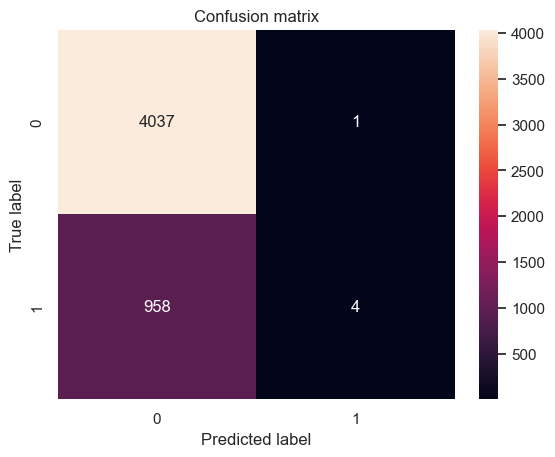

,Id,Predicted
0,2025000,0.131670
1,2025001,0.175248
2,2025002,0.132827
3,2025003,0.129370
4,2025004,0.391001


In [156]:
#Impplement CatBoost
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

modelCB = CatBoostClassifier(iterations=1000, learning_rate=0.069, depth=6, loss_function='Logloss', eval_metric='AUC', random_seed=32, od_type='Iter', metric_period=50)
modelCB.fit(X_train,y_train, eval_set=(X_test, y_test),use_best_model=True, verbose=True)

#predict on test set
probsCB=modelCB.predict_proba(test_processed.loc[:,features])[:,1]

#Print Model AUC
print('AUC of CatBoost model is',roc_auc_score(y_test, modelCB.predict_proba(X_test)[:,1]),'\n')

#print confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, modelCB.predict_proba(X_test)[:,1].round())

#plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, modelCB.predict_proba(X_test)[:,1].round())
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


submission = pd.DataFrame(columns = ['Id', 'Predicted'])
submission['Id'] = test['finance_order_id'].reset_index(drop=True)  # matching the id's of the test set, valid as long as we never permuted rows of the data
submission['Predicted'] = probsCB
submission.to_csv("CatBoostTest.csv",index = False)
submission.head()

In [135]:
modelCB = CatBoostClassifier(iterations=210, learning_rate=0.069, depth=6, loss_function='Logloss', eval_metric='AUC', random_seed=32, od_type='Iter', metric_period=50, one_hot_max_size=20)
modelCB.fit(training_processed.loc[:,features],y_train_full,use_best_model=True, verbose=True)


#predict on test set
probsCB=modelCB.predict_proba(test_processed.loc[:,features])[:,1]

#Print Model AUC
print('\nAUC of CatBoost model is',roc_auc_score(y_test, modelCB.predict_proba(X_test)[:,1]),'\n')

submission = pd.DataFrame(columns = ['Id', 'Predicted'])
submission['Id'] = test['finance_order_id'].reset_index(drop=True)  # matching the id's of the test set, valid as long as we never permuted rows of the data
submission['Predicted'] = probsCB
submission.to_csv("CBOverfit2.csv",index = False)
submission.head()

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	total: 40.8ms	remaining: 8.53s
50:	total: 1.42s	remaining: 4.43s
100:	total: 2.7s	remaining: 2.91s
150:	total: 3.91s	remaining: 1.53s
200:	total: 5.18s	remaining: 232ms
209:	total: 5.39s	remaining: 0us
AUC of CatBoost model is 0.788981288981289 



,Id,Predicted
0,2025000,0.131905
1,2025001,0.189939
2,2025002,0.125842
3,2025003,0.115955
4,2025004,0.280726
